### This notebook contains the first questions of our Assignment about Data Visualization, Cross Validation, Linear Regression and Logistic Regression

##### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn import metrics

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

##### Importing Dataset

In [2]:
dataset = pd.read_csv("Data/BTC-USD.csv")
print(dataset.shape)
dataset.head()

(1827, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000
1,2016-12-22,834.179993,875.781982,834.148987,864.539978,864.539978,200027008
2,2016-12-23,864.888000,925.117004,864.677002,921.984009,921.984009,275564000
3,2016-12-24,922.179993,923.479004,886.335022,898.822021,898.822021,137727008
4,2016-12-25,899.651978,899.651978,862.424011,896.182983,896.182983,143664992


In [3]:
dataset = dataset.sort_index()
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000
1,2016-12-22,834.179993,875.781982,834.148987,864.539978,864.539978,200027008
2,2016-12-23,864.888000,925.117004,864.677002,921.984009,921.984009,275564000
3,2016-12-24,922.179993,923.479004,886.335022,898.822021,898.822021,137727008
4,2016-12-25,899.651978,899.651978,862.424011,896.182983,896.182983,143664992


In [4]:
dataset.shape

(1827, 7)

We noticed that Close and Adj CLose columns are exactly the same.

In [5]:
(dataset['Close']-dataset['Adj Close']).sum()

0.0

Open The price of the coin at the beginning of the trading day. </br>

High: The highest price of the coin on a trading day. </br>

Low: The lowest price of the coin on a trading day. </br>

Close: The last price of the coin before the trading day ends. </br>

Volume is the amount of a token traded in a specific time interval. </br>

We converted Data column in datetime type to use it more efficiently

In [6]:
dataset["Date"]=pd.to_datetime(dataset['Date'])
dataset['Date']

0      2016-12-21
1      2016-12-22
2      2016-12-23
3      2016-12-24
4      2016-12-25
          ...    
1822   2021-12-17
1823   2021-12-18
1824   2021-12-19
1825   2021-12-20
1826   2021-12-21
Name: Date, Length: 1827, dtype: datetime64[ns]

In [7]:
dataset['Year'] = dataset['Date'].dt.year
dataset

,Date,Open,High,Low,Close,Adj Close,Volume,Year
0,2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000,2016
1,2016-12-22,834.179993,875.781982,834.148987,864.539978,864.539978,200027008,2016
2,2016-12-23,864.888000,925.117004,864.677002,921.984009,921.984009,275564000,2016
3,2016-12-24,922.179993,923.479004,886.335022,898.822021,898.822021,137727008,2016
4,2016-12-25,899.651978,899.651978,862.424011,896.182983,896.182983,143664992,2016
...,...,...,...,...,...,...,...,...
1822,2021-12-17,47653.730469,48004.894531,45618.214844,46202.144531,46202.144531,32902725329,2021
1823,2021-12-18,46219.253906,47313.828125,45598.441406,46848.777344,46848.777344,26098292690,2021
1824,2021-12-19,46853.867188,48089.664063,46502.953125,46707.015625,46707.015625,25154053861,2021
1825,2021-12-20,46707.062500,47401.718750,45579.808594,46880.277344,46880.277344,30961902129,2021


In [8]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume,Year
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1.827000e+03,1827.000000
mean,15208.247358,15629.267253,14746.920288,15231.832471,15231.832471,2.092230e+10,2018.971538
std,16829.476707,17296.796539,16289.465757,16838.811505,16838.811505,2.122934e+10,1.425115
min,775.177979,823.307007,755.755981,777.757019,777.757019,6.085170e+07,2016.000000
25%,5308.327637,5422.169434,5221.697753,5319.541504,5319.541504,4.474525e+09,2018.000000
50%,8585.262695,8744.828125,8313.340820,8595.740234,8595.740234,1.607165e+10,2019.000000
75%,13500.216309,13852.566406,12921.156250,13548.505860,13548.505860,3.260844e+10,2020.000000
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11,2021.000000


#### Preprocessing

In [9]:
dataset["Close"].shape

(1827,)

In [10]:
dataset['pos_neg']= dataset['Open']-dataset['Close']
dataset.head()
#if Open > Close then 0,else 1
dataset['Up/Down'] = np.where(dataset['pos_neg']>0, '0', '1')

We have to check for NaN values in our dataset

In [11]:
dataset.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Year         0
pos_neg      0
Up/Down      0
dtype: int64

In order to use MinMaxScaler, we have to check for zero values in our dataset because MinMaxScaler scales all the data features in the range [0, 1] or else in the range [-1, 1] if there are negative values in the dataset

In [12]:
(dataset['Open']< 0).sum()

0

In [13]:
(dataset['Close']< 0).sum()

0

In [14]:
(dataset['High']< 0).sum()

0

In [15]:
(dataset['Low']< 0).sum()

0

In [16]:
(dataset['Volume']< 0).sum()

0

#### Visualization

We used the next formula to check the relationship between the variables and we ended to the conclusion that there is a strong relationship between them.

In [17]:
model = sm.formula.ols(formula= "Close ~ High + Low + Open", data= dataset)
multi_reg = model.fit()
print(multi_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.198e+06
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        01:29:16   Log-Likelihood:                -13441.
No. Observations:                1827   AIC:                         2.689e+04
Df Residuals:                    1823   BIC:                         2.691e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6687     11.979      0.306      0.7

##### Diagrams

Text(0, 0.5, 'Daily Bitcoin price')

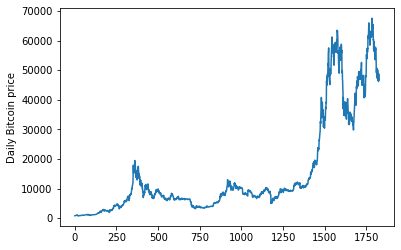

In [18]:
dataset['Close'].plot()
plt.ylabel("Daily Bitcoin price")

<AxesSubplot:xlabel='Year'>

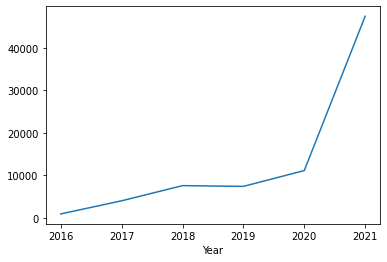

In [19]:
by_year = dataset['Close'].groupby(dataset['Year']).mean()
by_year.plot()

Text(0.5, 1.0, 'Volume trend')

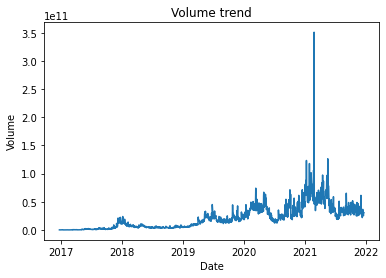

In [20]:
plt.plot('Date', 'Volume', data=dataset)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume trend')

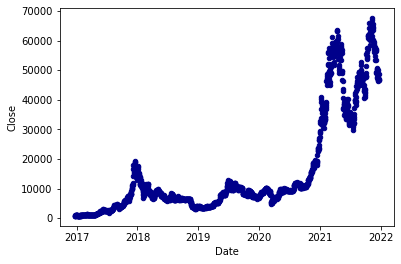

In [21]:
ax1 = dataset.plot.scatter(x='Date', y='Close', c='DarkBlue')

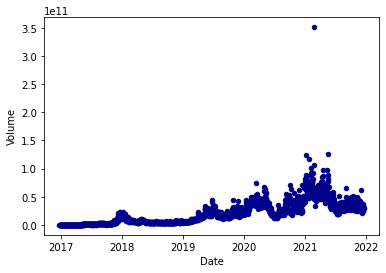

In [22]:
ax1 = dataset.plot.scatter(x='Date',
                      y='Volume',
                      c='DarkBlue')

#### Dataset scaling
We scaled our dataset using MinMaxScaler

In [23]:
scaled_data = dataset[['Open', 'High', 'Low', 'Close', 'Volume']]
scaler = MinMaxScaler(copy=False)
scaled_data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(scaled_data[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_data

C:\Users\Μαρίνα Σαμ\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,Open,High,Low,Close,Volume
0,0.000381,0.000161,0.000665,0.000846,0.000270
1,0.000884,0.000772,0.001195,0.001299,0.000397
2,0.001343,0.001498,0.001660,0.002159,0.000612
3,0.002201,0.001474,0.001990,0.001813,0.000219
4,0.001864,0.001123,0.001625,0.001773,0.000236
...,...,...,...,...,...
1822,0.702042,0.694191,0.683605,0.680117,0.093591
1823,0.680560,0.684023,0.683304,0.689799,0.074200
1824,0.690064,0.695438,0.697086,0.687676,0.071510
1825,0.687865,0.685316,0.683020,0.690270,0.088060


In [24]:
scaled_data["Up/Down"] = dataset["Up/Down"].copy()

C:\Users\DD7D~1\AppData\Local\Temp/ipykernel_22036/2909746662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data["Up/Down"] = dataset["Up/Down"].copy()


Now we are ready to create our models!

## Linear Regression 

###### Creating X and y variables

In [25]:
X = scaled_data[['Open', 'High', 'Low', 'Volume']]
y = scaled_data['Close']

##### Splitting the Data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1278, 4)
(1278,)
(549, 4)
(549,)


##### Cross Validation Score and Predict Score

In [27]:
cv = KFold(n_splits=5,random_state=1,shuffle=True)
linReg=LinearRegression()
scores=cross_val_score(linReg,X,y,scoring='r2',cv=cv,n_jobs=1)
scores

array([0.99935064, 0.99958251, 0.99944464, 0.9995516 , 0.99946571])

In [28]:
predicted = cross_val_predict(linReg,X,y,cv=6)
scores = cross_val_score(linReg,X,y,scoring='r2',cv=36,n_jobs=1)
scores

array([0.95772199, 0.97009387, 0.99448602, 0.83516577, 0.99579914,
       0.98693561, 0.99374616, 0.98506312, 0.95143225, 0.98819799,
       0.98931556, 0.981374  , 0.96375516, 0.99472029, 0.93720653,
       0.97769643, 0.99100604, 0.98954583, 0.92638594, 0.98751599,
       0.96805509, 0.97104131, 0.98278395, 0.93450817, 0.9239199 ,
       0.9903205 , 0.97091738, 0.99741826, 0.99115817, 0.98716627,
       0.95650016, 0.98858075, 0.93492802, 0.968624  , 0.99184334,
       0.98126483])

##### Plots

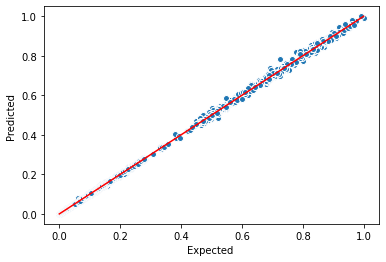

In [29]:
fig,ax = plt.subplots()
ax.scatter(y,predicted,edgecolors=(1,1,1))
ax.plot([y.min(),y.max()],[y.min(),y.max()],color='red')
ax.set_xlabel('Expected ')
ax.set_ylabel('Predicted ')
plt.show()

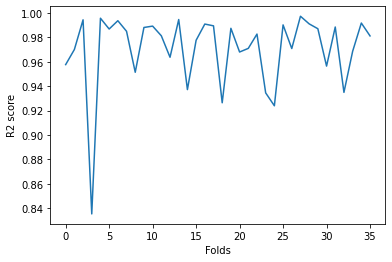

In [30]:
fig,ax = plt.subplots()
plt.plot(scores)
ax.set_xlabel('Folds')
ax.set_ylabel('R2 score')
plt.show()

##### Training the Model using KFold split

In [31]:
kf = KFold(n_splits=10,shuffle=True)
scores = []
errors = []
i=1

for training,testing in kf.split(X,y):
    X_train,X_test = X.loc[training],X.loc[testing]
    y_train,y_test = y.loc[training],y.loc[testing]
    print ('{}/10 Folds {}'.format(i,kf.n_splits))
    print('--------------------------')
    
    linReg=LinearRegression()
    linReg.fit(X_train,y_train)
    score=metrics.r2_score(y_test,linReg.predict(X_test))
    error=metrics.mean_squared_error(y_test,linReg.predict(X_test))
    print('R2 Score: ',score)
    print('MSE: ',error)
    scores.append(score)
    errors.append(error)
    print('\n')
    i+=1

1/10 Folds 10
--------------------------
R2 Score:  0.9995398807320844
MSE:  2.8631499743970446e-05


2/10 Folds 10
--------------------------
R2 Score:  0.9994481926609659
MSE:  3.8406796330193415e-05


3/10 Folds 10
--------------------------
R2 Score:  0.999472940976084
MSE:  3.3394175946781524e-05


4/10 Folds 10
--------------------------
R2 Score:  0.9995253227874009
MSE:  2.8877861786018528e-05


5/10 Folds 10
--------------------------
R2 Score:  0.9994236594444835
MSE:  3.775395762328563e-05


6/10 Folds 10
--------------------------
R2 Score:  0.9995658167488685
MSE:  2.4817816225633753e-05


7/10 Folds 10
--------------------------
R2 Score:  0.9994601025239357
MSE:  3.1928189407889475e-05


8/10 Folds 10
--------------------------
R2 Score:  0.999098549680346
MSE:  4.877069509649956e-05


9/10 Folds 10
--------------------------
R2 Score:  0.9995074170559974
MSE:  3.055756769087731e-05


10/10 Folds 10
--------------------------
R2 Score:  0.9996516673863639
MSE:  2.7314846

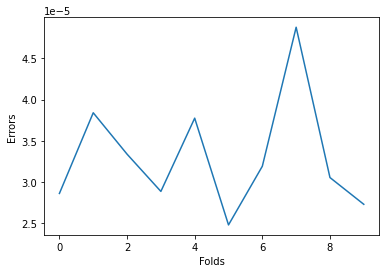

In [32]:
fig,ax = plt.subplots()
plt.plot(errors)
ax.set_xlabel('Folds')
ax.set_ylabel('Errors')
plt.show()

In [33]:
print("Coefficients: \n", linReg.coef_)
print("Intercept: \n", linReg.intercept_)

Coefficients: 
 [-0.53214306  0.93866156  0.59316676  0.00185983]
Intercept: 
 0.0004018652982362425


##### Testing the Model

In [34]:
y_pred_lin = linReg.predict(X_test)
dfp = pd.DataFrame({'Actual_Price': y_test, 'Predicted_Price': y_pred_lin})
dfp.head()

,Actual_Price,Predicted_Price
12,0.003653,0.003674
13,0.003984,0.003891
29,0.001816,0.001785
44,0.003775,0.003715
53,0.003315,0.003268


##### Polynomial Equation

In [35]:
y = linReg.coef_[0] * X_test['Open'] + linReg.coef_[1] * X_test['High'] + linReg.coef_[2] * X_test['Low'] + linReg.coef_[3] * X_test['Volume'] + linReg.intercept_

##### Plotting

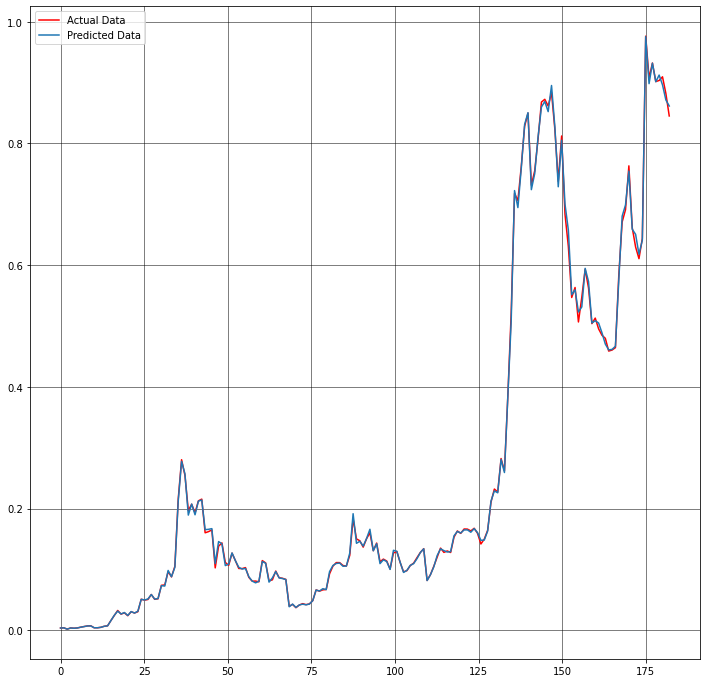

In [36]:
plt.subplots(1, figsize=(12,12))
plt.plot(np.linspace(0, y_test.size, y_test.size), y_test, color='red', label='Actual Data')
plt.plot(np.linspace(0, y_test.size, y_test.size), y, label='Predicted Data')
#plt.xlabel('Expected')
#plt.ylabel('Predicted')
plt.grid(color='#000000', linestyle='-', linewidth=0.5)
plt.legend(loc="upper left")

##### Scatter plot

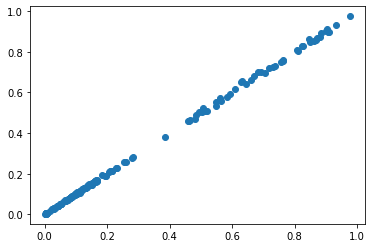

In [37]:
plt.scatter(dfp['Actual_Price'], dfp['Predicted_Price'])

In [38]:
reg_score = linReg.score(X_test, y_test)
print("Linear Regression Score: ", reg_score)
print("Absolute Squared Error: ", mean_absolute_error(y_test, y_pred_lin))
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred_lin))

Linear Regression Score:  0.9996516673863639
Absolute Squared Error:  0.0030259435900967997
Mean Squared Error:  2.731484624722737e-05


As we can see, the score is extremely high and our model's predicitons are so different from the expected values.

## Logistic Regression 

##### Creating X and y variables

In [39]:
X = scaled_data[['Open', 'High', 'Low', 'Close','Volume']]
y = scaled_data["Up/Down"].values

##### Splitting the data

In [40]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1370, 5)
(1370,)
(457, 5)
(457,)


##### Training 

In [42]:
cv = KFold(n_splits=5,random_state=1,shuffle=True)
lr=LogisticRegression()
scores=cross_val_score(lr,X,y,scoring='roc_auc',cv=cv,n_jobs=1)
scores

array([0.58345674, 0.68588457, 0.58925665, 0.58278146, 0.62585219])

In [43]:
predicted = cross_val_predict(lr,X,y,cv=6)
scores = cross_val_score(lr,X,y,scoring='roc_auc',cv=36,n_jobs=1)
scores

array([0.97515528, 0.98757764, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.95186335, 0.55279503, 0.76397516,
       0.73291925, 0.87267081, 0.77329193, 0.58229814, 0.6863354 ,
       0.99068323, 0.98913043, 0.97360248, 0.71273292, 0.69875776,
       0.81987578, 0.93167702, 0.88198758, 0.74068323, 0.58695652,
       0.72515528, 0.8431677 , 0.78743961, 0.98872786, 0.99516908,
       0.96940419, 0.64090177, 0.94041868, 0.98550725, 0.96618357,
       0.92431562])

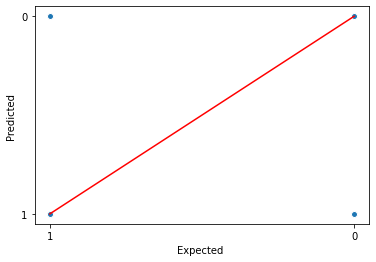

In [44]:
fig,ax = plt.subplots()
ax.scatter(y,predicted,edgecolors=(1,1,1))
ax.plot([y.min(),y.max()],[y.min(),y.max()],color='red')
ax.set_xlabel('Expected ')
ax.set_ylabel('Predicted ')
plt.show()

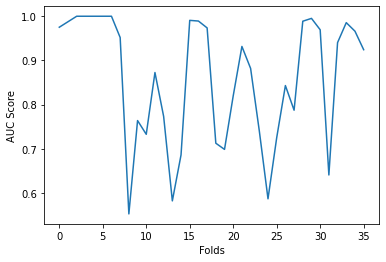

In [45]:
fig,ax = plt.subplots()
plt.plot(scores)
ax.set_xlabel('Folds')
ax.set_ylabel('AUC Score')
plt.show()

In [46]:
'''kf = KFold(n_splits=10,shuffle=True)
scores = []
errors=[]
i=1

for training,testing in kf.split(X,y):
    X_train,X_test = X.loc[training],X.loc[testing]
    y_train,y_test = y.loc[training],y.loc[testing]
    
    print ('{}/10 Folds {}'.format(i,kf.n_splits))
    print('--------------------------')
    
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    score=metrics.roc_auc_score(y_test,lr.predict(X_test))
    error=metrics.log_loss(y_test,lr.predict(X_test))
    print('ROC AUC Score: ',score)
    print('Loss: ',error)
    scores.append(score)
    errors.append(error)
    i+=1'''

"kf = KFold(n_splits=10,shuffle=True)\nscores = []\nerrors=[]\ni=1\n\nfor training,testing in kf.split(X,y):\n    X_train,X_test = X.loc[training],X.loc[testing]\n    y_train,y_test = y.loc[training],y.loc[testing]\n    \n    print ('{}/10 Folds {}'.format(i,kf.n_splits))\n    print('--------------------------')\n    \n    lr=LogisticRegression()\n    lr.fit(X_train,y_train)\n    score=metrics.roc_auc_score(y_test,lr.predict(X_test))\n    error=metrics.log_loss(y_test,lr.predict(X_test))\n    print('ROC AUC Score: ',score)\n    print('Loss: ',error)\n    scores.append(score)\n    errors.append(error)\n    i+=1"

##### Creating the model

In [47]:
lr=LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [48]:
y_pred_log = lr.predict(X_test)
dfp = pd.DataFrame({'Actual_Price': y_test, 'Predicted_Price': y_pred_log})
dfp.head()

,Actual_Price,Predicted_Price
0,1,1
1,1,1
2,1,0
3,1,1
4,0,1


In [49]:
y_pred_log = lr.predict(X_test)
y_pred_log_probs = lr.predict_proba(X_test)[:,1]

test_accuracy = accuracy_score(y_test, y_pred_log)
test_auc_roc = roc_auc_score(y_test, y_pred_log_probs)

print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_log))

print('Testing AUC: ', test_auc_roc)

print('Testing accuracy: ' , test_accuracy)

Confusion matrix:
 [[ 34 167]
 [ 37 219]]
Testing AUC:  0.5431242226368159
Testing accuracy:  0.5536105032822757


##### Metrics

In [50]:
score=metrics.roc_auc_score(y_test,lr.predict(X_test))
error=metrics.log_loss(y_test,lr.predict(X_test))
print('ROC AUC Score: ',score)
print('Loss: ',error)

ROC AUC Score:  0.5123114894278606
Loss:  15.418039206417115


In [51]:
print(classification_report(y_test, y_pred_log, digits=2))

              precision    recall  f1-score   support

           0       0.48      0.17      0.25       201
           1       0.57      0.86      0.68       256

    accuracy                           0.55       457
   macro avg       0.52      0.51      0.47       457
weighted avg       0.53      0.55      0.49       457



As we can see, we are not satisfied from the score that Logistic Regression returns. </br>
Next Step, Neural Network